## Simple source modeling
Trying to iron out all the confusion on how to calculate source parameters

In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

t, a, b, c, f = sym.symbols('t a b c f')

## Source Model

We will use a simple guassian as a source model.

In [2]:
# Get gausian and derivative/integral
gaus = a * sym.exp((-(t - b)**2) / (2 * c **2))
d_gaus = sym.diff(gaus, t)
int_gaus = sym.integrate(gaus, t)

In [3]:
# get freq domain
F_gaus = sym.fourier_transform(gaus, t, f).rewrite(sym.Integral)
F_d_gaus = sym.fourier_transform(d_gaus, t, f).rewrite(sym.Integral)
F_int_gaus = sym.fourier_transform(int_gaus, t, f).rewrite(sym.Integral)

In [4]:
gaus

a*exp(-(-b + t)**2/(2*c**2))

In [5]:
d_gaus

-a*(-2*b + 2*t)*exp(-(-b + t)**2/(2*c**2))/(2*c**2)

## Get numpy functions

In [6]:
get_gaus = sym.lambdify([t, a, b, c], gaus)
get_d_gaus = sym.lambdify([t, a, b, c], d_gaus)
get_int_gaus = sym.lambdify([t, a, b, c], int_gaus)

## Next generate source time series and plot

In [9]:
# get source in 1) displacement 2) velocity
dt = 0.01
a, b, c = 0.1, 5, np.sqrt(2)
# x = np.arange(0, 10/2, dt)
x = np.arange(0, 10, dt)

# Without zero-padding
source_disp = np.zeros(len(x))
source_disp[0:len(x)] = get_gaus(x, a=a, b=b, c=c)
source_vel = np.zeros(len(x))
source_vel[0:len(x)] = get_d_gaus(x, a=a, b=b, c=c)


Text(0, 0.5, 'displacement amplitude (m)')

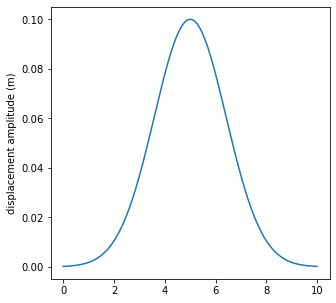

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.plot(x, source_disp)
# plt.plot(x, source_disp)
ax1.set_ylabel('displacement amplitude (m)')

Text(0, 0.5, 'velocity amplitude (m/s)')

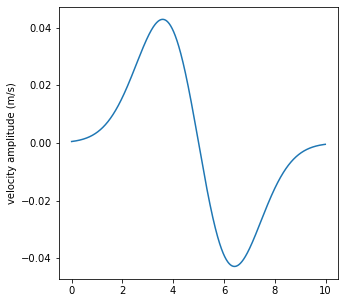

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.plot(x, source_vel)
ax1.set_ylabel('velocity amplitude (m/s)')

## Convert to the frequency domain and plot

In [17]:
def get_fft(ar, dt):
    """Return the fft of the array and its """
    fft_ar = np.fft.rfft(ar)
    freq = np.fft.rfftfreq(len(ar), dt)
    return freq, fft_ar

In [19]:
freqs, source_disp_fft = get_fft(source_disp, dt)


Text(0, 0.5, 'amplitude')

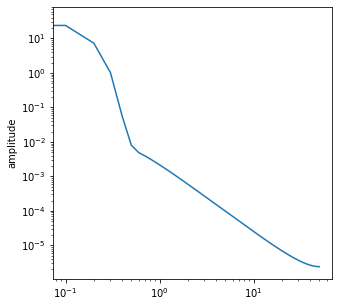

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.loglog(freqs, abs(source_disp_fft))
ax1.set_ylabel('amplitude')

### Convert back to the time domain and plot to make sure you get the input back

Note that it is necessary to divide by the sample spacing to get the correct amplitude...

In [13]:
source_disp_rev = np.fft.irfft(source_disp_fft)

NameError: name 'source_disp_rev' is not defined

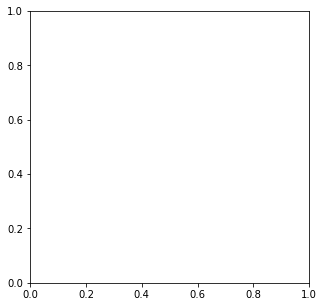

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.plot(x, source_disp_rev)
ax1.set_ylabel('displacement amplitude (m)')

## Do the derivative in the time domain

In [15]:
vel = np.gradient(source_disp, dt)

## Repeat in the frequency domain and convert back to the time domain

In [16]:
vel_fft = 1j * 2 * np.pi * freqs * source_disp_fft
vel_td = np.fft.irfft(vel_fft)

dis_vel_fft = 1j * 2 * np.pi * freqs * dis_source_disp_fft
dis_vel_td = np.fft.irfft(dis_vel_fft)

zp_vel_fft = 1j * 2 * np.pi * freqs * zp_source_disp_fft
zp_vel_td = np.fft.irfft(zp_vel_fft)

## Plot the analytical, numerical, and fft solutions and compare

(-0.25, 0.25)

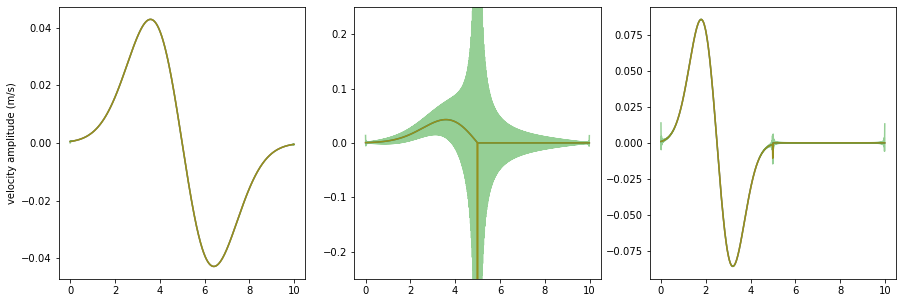

In [17]:
fig, (ax1,) = plt.subplots(1, 1, figsize=(5,5))

ax1.plot(x, source_vel)
ax1.plot(x, vel)
ax1.plot(x, vel_td, alpha=0.5)

ax1.set_ylabel('velocity amplitude (m/s)')

ax2.set_ylim(-0.25, 0.25)

In [18]:
print("Max Diffs:", (source_vel - vel_td).max(), (dis_source_vel - dis_vel_td).max(), (zp_source_vel - zp_vel_td).max())

Max Diffs: 0.00048261353405845367 6.9314778409005235 0.013869083404506972


### Plot the FFTs from each solution and compare

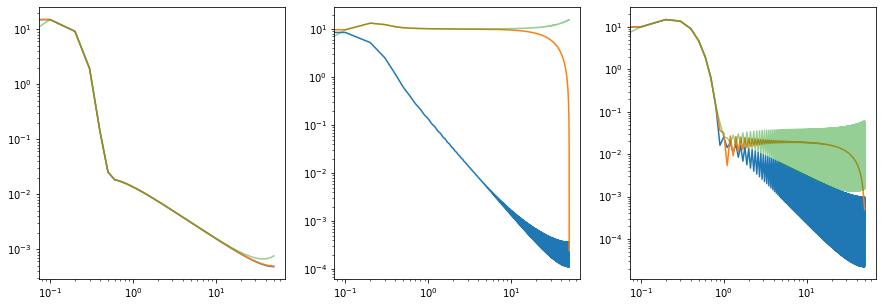

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.loglog(freqs, abs(np.fft.rfft(source_vel)))
ax1.loglog(freqs, abs(np.fft.rfft(vel)))
ax1.loglog(freqs, abs(vel_fft), alpha=0.5)

ax2.loglog(freqs, abs(np.fft.rfft(dis_source_vel)))
ax2.loglog(freqs, abs(np.fft.rfft(dis_vel)))
ax2.loglog(freqs, abs(dis_vel_fft), alpha=0.5)
           
ax3.loglog(freqs, abs(np.fft.rfft(zp_source_vel)))
ax3.loglog(freqs, abs(np.fft.rfft(zp_vel)))
ax3.loglog(freqs, abs(zp_vel_fft), alpha=0.5)

## Energy
Next we estimate energy and the equivalent in the freq domain.

## Time domain energy

In [20]:
source_energy = source_vel ** 2
dis_source_energy = dis_source_vel ** 2
zp_source_energy = zp_source_vel ** 2

Text(0, 0.5, 'amplitude (m^2/s^2)')

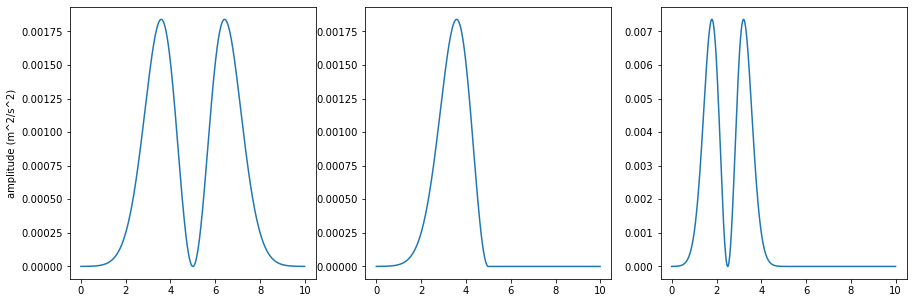

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(x, source_energy)
ax2.plot(x, dis_source_energy)
ax3.plot(x, zp_source_energy)
ax1.set_ylabel('amplitude (m^2/s^2)')

In [22]:
# energy_td = np.trapz(source_energy, dx=dt)
energy_td = np.sum(source_energy)
dis_energy_td = np.sum(dis_source_energy[0:len(x)//2])  # This should be half the energy of the first (and zero padding shouldn't make a big difference?)
zp_energy_td = np.sum(zp_source_energy[0:len(x)//2])  # This should be twice the energy of the first because it's higher frequency (again, zero padding doesn't actuall matter)
print(energy_td, dis_energy_td, zp_energy_td)

0.6266473909747177 0.31332381194527054 1.2532947712369067


## Frequency domain energy

In [34]:
def get_ppsd(fft, n, dt):
    """Get the power spectral density? Or something close to it ;)"""
#     print(abs(fft).min(), abs(fft).max())
    fft_ar_sq = fft ** 2
#     print(abs(fft_ar_sq).min(), abs(fft_ar_sq).max())
    out = fft_ar_sq * (dt / n)
#     print(abs(out).min(), abs(out).max())
    # double non zero components to account for neg. frequencies
    out[1:] *= 2
#     print(abs(out).min(), abs(out).max())
    freq = np.fft.rfftfreq(n, dt)
    return freq, out

In [29]:
freqs, ppsd_analytic = get_ppsd(np.fft.rfft(source_vel), len(source_vel), dt) # Analytical
freqs, ppsd_time = get_ppsd(np.fft.rfft(vel), len(source_vel), dt) # Get velocity in time domain (should pretty closely match the analytical solution)
freqs, ppsd_freq = get_ppsd(vel_fft, len(source_vel), dt) # Get velocity in frequency domain

freqs, dis_ppsd_analytic = get_ppsd(np.fft.rfft(dis_source_vel), len(dis_source_vel), dt) # Analytical
freqs, dis_ppsd_time = get_ppsd(np.fft.rfft(dis_vel), len(dis_source_vel), dt) # Get velocity in time domain
freqs, dis_ppsd_freq = get_ppsd(dis_vel_fft, len(dis_source_vel), dt) # Get velocity in frequency domain

freqs, zp_ppsd_analytic = get_ppsd(np.fft.rfft(zp_source_vel), len(zp_source_vel), dt) # Analytical
freqs, zp_ppsd_time = get_ppsd(np.fft.rfft(zp_vel), len(zp_source_vel), dt) # Get velocity in time domain
freqs, zp_ppsd_freq = get_ppsd(zp_vel_fft, len(zp_source_vel), dt) # Get velocity in frequency domain

0.01 1000
0.01 1000
0.01 1000
0.01 1000
0.01 1000
0.01 1000
0.01 1000
0.01 1000
0.01 1000


Text(0, 0.5, 'amplitude (m^2/s^2)')

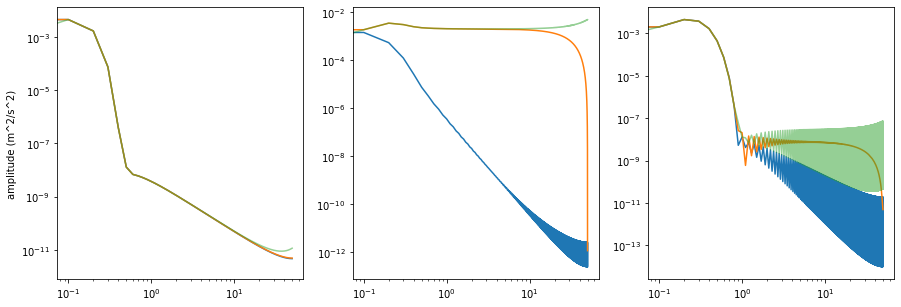

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.loglog(freqs, abs(ppsd_analytic))
ax1.loglog(freqs, abs(ppsd_time))
ax1.loglog(freqs, abs(ppsd_freq), alpha=0.5)

ax2.loglog(freqs, abs(dis_ppsd_analytic))
ax2.loglog(freqs, abs(dis_ppsd_time))
ax2.loglog(freqs, abs(dis_ppsd_freq), alpha=0.5)

ax3.loglog(freqs, abs(zp_ppsd_analytic))
ax3.loglog(freqs, abs(zp_ppsd_time))
ax3.loglog(freqs, abs(zp_ppsd_freq), alpha=0.5)

ax1.set_ylabel('amplitude (m^2/s^2)')

In [31]:
import pandas as pd
df = pd.DataFrame(columns=["Integrated Velocity", "Analytical Velocity by PPSD", "Time Domain Velocity by PPSD", "Frequency Domain Velocity by PPSD", "Ratio"])
# Continuous pulse
integrated = np.trapz(source_vel**2, dx=dt)
analytic = np.sum(abs(ppsd_analytic))
td = np.sum(abs(ppsd_time))
fd = np.sum(abs(ppsd_freq))
ratio = td/fd
df.loc["Continuous"] = [integrated, analytic, td, fd, ratio]
# Discontinuity
integrated = np.trapz(dis_source_vel**2, dx=dt)
analytic = np.sum(abs(dis_ppsd_analytic))
td = np.sum(abs(dis_ppsd_time))
fd = np.sum(abs(dis_ppsd_freq))
ratio = td/fd
df.loc["Discontinuity"] = [integrated, analytic, td, fd, ratio]
# Zero padded (half-width pulse)
integrated = np.trapz(zp_source_vel**2, dx=dt)
analytic = np.sum(abs(zp_ppsd_analytic))
td = np.sum(abs(zp_ppsd_time))
fd = np.sum(abs(zp_ppsd_freq))
ratio = td/fd
df.loc["Zero Padded"] = [integrated, analytic, td, fd, ratio]

In [27]:
df

,Integrated Velocity,Analytical Velocity by PPSD,Time Domain Velocity by PPSD,Frequency Domain Velocity by PPSD,Ratio
Continuous,0.006266,0.006266,0.006266,0.006266,0.999975
Discontinuity,0.003133,0.003133,0.503071,1.391847,0.361441
Zero Padded,0.012533,0.012533,0.012534,0.012544,0.999218


In [32]:
td

0.012533851030641658

In [33]:
fd

0.012543662696003155